<a href="https://colab.research.google.com/github/eriksali/DNN_2023_DL/blob/main/certify_cifar10_radius_random_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
##from models import ResNet18 # Import your ResNet18 model
##from certify import certify # Import the certify function from the provided code
##from attacks import pgd_attack # Import the PGD attack function from the provided code

import torch
import torchvision.models as models

# Download ResNet18 and set the pretrained parameter to True
resnet18 = models.resnet18(pretrained=True)


# Set up the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define the ResNet18 model and optimizer
##net = ResNet18()
net = resnet18
net = net.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Train the ResNet18 model
for epoch in range(2):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_acc = 100. * correct / total

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_acc = 100. * correct / total

    print('Epoch [%d/%d] Train Loss: %.3f Train Acc: %.3f Test Loss: %.3f Test Acc: %.3f' % (
        epoch + 1, 200, train_loss, train_acc, test_loss, test_acc))

###############################################################################
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats import norm

'''def certify(model, x, sigma, num_samples, beta):
    """
    Compute the certified radius for a given input using randomized smoothing.

    Args:
        model (nn.Module): the neural network model to certify
        x (Tensor): the input image for which to compute the certified radius
        sigma (float): the standard deviation of the Gaussian noise used for randomized smoothing
        num_samples (int): the number of samples used to estimate the robustness of the smoothed classifier
        beta (float): the confidence level of the certification

    Returns:
        float: the certified radius of the input
    """
    # Set the model to evaluation mode
    model.eval()

    # Compute the standard deviation of the noise after normalization
    sigma_norm = sigma / np.sqrt(np.prod(x.shape[1:]))

    # Generate a batch of samples from the input with Gaussian noise
    x_samples = torch.tensor(
        np.random.normal(loc=x, scale=sigma_norm, size=(num_samples, *x.shape)).astype(np.float32)
    )

    # Evaluate the model on the noisy samples
    with torch.no_grad():
        logits = model(x_samples)

    # Compute the maximum logit across the samples
    max_logits, _ = logits.max(dim=1)

    # Compute the threshold for the certified radius
    threshold = norm.ppf(beta) * max_logits.std() + max_logits.mean()

    # Compute the certified radius
    radius = sigma * norm.ppf(beta) / (max_logits - threshold).abs().max().sqrt().item()

    return radius'''


sigma = 0.25
num_samples = 100
beta = 0.1

# Compute the certified radius for the first image in the test set
x, y = next(iter(testloader))
x, y = x.to(device), y.to(device)
radius = certify(resnet18, x[0], sigma, num_samples, beta)
print(f"Certified radius for image 0: {radius:.4f}")

###############################################################################

import torch
import torch.nn.functional as F

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """
    PGD attack on a neural network model.

    Args:
        model (nn.Module): the neural network model to attack
        x (Tensor): the input image to attack
        y (Tensor): the true label of the input image
        epsilon (float): the maximum perturbation allowed
        alpha (float): the step size of the attack
        num_iter (int): the number of iterations of the attack

    Returns:
        Tensor: the perturbed image
    """
    # Create a copy of the input image for the attack
    x_adv = x.clone().detach()

    # Set the image to require gradient
    x_adv.requires_grad = True

    # PGD attack loop
    for i in range(num_iter):
        # Zero out the gradient
        model.zero_grad()

        # Forward pass to get the logits
        logits = model(x_adv)

        # Compute the loss as the cross-entropy between the logits and the true label
        loss = F.cross_entropy(logits, y)

        # Backward pass to compute the gradient
        loss.backward()

        # Compute the sign of the gradient
        grad = x_adv.grad.detach().sign()

        # Update the perturbed image
        x_adv = x_adv + alpha * grad

        # Clip the perturbation to epsilon
        x_adv = torch.max(torch.min(x_adv, x + epsilon), x - epsilon)

        # Clamp the perturbed image to [0, 1]
        x_adv = torch.clamp(x_adv, 0, 1)

        # Detach the gradient to prevent it from accumulating
        x_adv = x_adv.detach()

    return x_adv

###############################################################################

# Generate the certified radii for the ResNet18 model on CIFAR-10
certified_radii = certify(net, testloader, device=device, num_classes=10)

# Evaluate the ResNet18 model against PGD attacks
epsilons = [0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
for epsilon in epsilons:
    print(f"PGD Attack with epsilon={epsilon}")
    correct = 0
    total = 0
    net.eval()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        adv_inputs = pgd_attack(net, inputs, targets, epsilon, 20, 0.01, device=device) # Use PGD to generate adversarial examples
        outputs = net(adv_inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
print(f"Accuracy under PGD attack with epsilon {epsilon} : {acc:.2f} %")





Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200] Train Loss: 998.180 Train Acc: 18.840 Test Loss: 182.821 Test Acc: 26.410
Epoch [2/200] Train Loss: 695.170 Train Acc: 32.270 Test Loss: 128.920 Test Acc: 36.630
Certified radius for image 0: -1.5672


TypeError: ignored

In [ ]:
import math


def certify_sample(model, x, y_pred, sigma, num_samples, beta):
    """
    Computes the certified radius for a single input using randomized smoothing.

    Arguments:
        model: A PyTorch model to certify.
        x: The input tensor to certify.
        y_pred: The model's predicted output for the input x.
        sigma: The standard deviation of the Gaussian noise to add to the input during smoothing.
        num_samples: The number of samples to use for smoothing.
        beta: The confidence level for the certification, which determines the radius of the certified set.

    Returns:
        The certified radius for the input x.
    """

    # Set the model to evaluation mode
    model.eval()

    # Compute the perturbation standard deviation for the given sigma and beta
    delta = sigma * math.sqrt(num_samples - 1) * norm.ppf(1 - beta / 2)

    # Compute the smoothed predictions for the input x
    y_smooth = torch.zeros((num_samples,) + y_pred.shape, dtype=y_pred.dtype, device=y_pred.device)
    for i in range(num_samples):
        noise = torch.randn_like(x) * sigma
        y_smooth[i] = model(x + noise)
    y_smooth = y_smooth.softmax(dim=-1)

    # Compute the predicted class probabilities for the smoothed predictions
    y_bar = y_smooth.mean(dim=0)

    # Compute the distance between the original predictions and the smoothed predictions
    d = (y_pred.softmax(dim=-1) - y_bar).norm(p=2)

    # Compute the certified radius
    r = delta + d.item()

    return r


def certify(model, dataset, sigma, num_samples, beta):
    """
    Computes certified radii for a PyTorch model using randomized smoothing.

    Arguments:
        model: A PyTorch model to certify.
        dataset: A PyTorch dataset containing the data to certify.
        sigma: The standard deviation of the Gaussian noise to add to the input during smoothing.
        num_samples: The number of samples to use for smoothing.
        beta: The confidence level for the certification, which determines the radius of the certified set.

    Returns:
        A numpy array of certified radii, one for each input in the dataset.
    """

    # Set the model to evaluation mode
    model.eval()

    # Determine the size of the dataset
    n = len(dataset)

    # Compute the certified radii for each input in the dataset
    certified_radii = np.zeros(n)
    for i in range(n):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)
        y_pred = model(x)
        r = certify_sample(model, x, y_pred, sigma, num_samples, beta)
        certified_radii[i] = r

    return certified_radii


# Generate the certified radii for the ResNet18 model on CIFAR-10

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

# Load the CIFAR-10 test dataset
testset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Create a data loader for the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Define the standard deviation, number of samples, and confidence level for certification
sigma = 0.25
num_samples = 100
beta = 0.001

# Call the certify function with the test dataset and the certification parameters
certified_radii = certify(net, testset, sigma, num_samples, beta)



# Evaluate the ResNet18 model against PGD attacks
epsilons = [0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
for epsilon in epsilons:
    print(f"PGD Attack with epsilon={epsilon}")
    correct = 0
    total = 0
    net.eval()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        adv_inputs = pgd_attack(net, inputs, targets, epsilon, 20, 0.01, device=device) # Use PGD to generate adversarial examples
        outputs = net(adv_inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
print(f"Accuracy under PGD attack with epsilon {epsilon} : {acc:.2f} %")


Files already downloaded and verified


In [ ]:
'''
This code trains the neural network f using randomized smoothing with Gaussian data augmentation at variance σ2=0.25. In each epoch, it first generates smoothed labels for each input image in the training set and then performs forward and backward passes to update the model parameters using the cross-entropy loss between the predicted and smoothed labels. It then evaluates the model on the validation set by computing the accuracy of the smoothed classifier g that is defined using f and σ2=0.25. 
The training progress is printed for each epoch, and the final accuracy on the validation set is also displayed.
'''
!curl -O https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar xzf imagenette2.tgz
'''import torchvision.datasets as datasets

imagenette = datasets.ImageFolder('imagenette2/train')'''


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1485M  100 1485M    0     0  14.9M      0  0:01:39  0:01:39 --:--:-- 15.5M


"import torchvision.datasets as datasets\n\nimagenette = datasets.ImageFolder('imagenette2/train')"

In [ ]:
!pip install torch torchvision
!pip install adversarial-robustness-toolbox --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
##from art.defences.trainer import DefenseGAN
from art.defences.gan import DefenseGAN
from art.defences.postprocessor import JpegCompression
from art.defences.postprocessor import BitSqueezing
from art.defences.postprocessor import GaussianNoise
from art.defences.postprocessor import SpatialSmoothing
from art.defences.postprocessor import LabelSmoothing
from art.defences.postprocessor import TotalVarMin
from art.defences.postprocessor import PixelDefend
from art.defences.postprocessor import HighConfidence
from art.defences.postprocessor import FeatureSqueezing
from art.defences.postprocessor import ImageCompression
from art.defences.postprocessor import JPEGFilter
from art.defences.postprocessor import PixelDiscretization
from art.defences.postprocessor import VideoCompression
from art.defences.preprocessor import JpegCompression
from art.defences.preprocessor import BitSqueezing
from art.defences.preprocessor import GaussianNoise
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import LabelSmoothing
from art.defences.preprocessor import TotalVarMin
from art.defences.preprocessor import PixelDefend
from art.defences.preprocessor import HighConfidence
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import ImageCompression
from art.defences.preprocessor import JPEGFilter
from art.defences.preprocessor import PixelDiscretization
from art.defences.preprocessor import VideoCompression

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(64 * 8 * 8, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)
loss_fn = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
classifier = PyTorchClassifier(model=model, clip_values=(0, 1), loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10)

epochs = 20
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Reset optimizer gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        '''# Print training progress
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))'''
        
        # Evaluate model on clean validation set
        if batch_idx % eval_interval == 0:
            clean_acc = evaluate(model, device, val_loader)
            print('Clean Accuracy: {:.2f}%'.format(100. * clean_acc))
            
        # Evaluate model on adversarial validation set
        if batch_idx % eval_interval == 0:
            adv_acc = evaluate_adv(model, device, val_loader, epsilon, num_samples, alpha)
            print('Adversarial Accuracy: {:.2f}%'.format(100. * adv_acc))
            
        # Save model checkpoint
        if save_model and (batch_idx % checkpoint_interval == 0):
            torch.save(model.state_dict(), model_path)
            print('Model saved to {}'.format(model_path))

                
            



ModuleNotFoundError: ignored

In [ ]:
!pip install torch torchvision matplotlib
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)

def f(x):
    return model(x)

def randomized_smoothing(x, model, n_samples, sigma):
    logits = torch.zeros((len(x), 10)).to(device)
    for i in range(n_samples):
        noise = sigma * torch.randn_like(x).to(device)
        logits += f(x + noise)
    return logits / n_samples


class SmoothClassifier(nn.Module):
    def __init__(self, f, sigma):
        super(SmoothClassifier, self).__init__()
        self.f = f
        self.sigma = sigma
        
    def forward(self, x):
        logits = torch.zeros((len(x), 10)).to(device)
        for i in range(n_samples):
            noise = self.sigma * torch.randn_like(x).to(device)
            logits += self.f(x + noise)
        return logits / n_samples


def certified_accuracy(model, test_loader, n_samples, sigma, alpha):
    smooth_classifier = SmoothClassifier(f, sigma)
    smooth_classifier = smooth_classifier.to(device)

    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Smooth the images
        smoothed_logits = randomized_smoothing(images, model, n_samples, sigma)
        smoothed_probs = F.softmax(smoothed_logits, dim=1)

        # Compute the lower and upper bounds for each image
        lower_bounds, upper_bounds = smoothed_probs.sort(dim=1)[0][:, -2:]
        radius = (upper_bounds - lower_bounds).max(dim=1)[0]

        # Check if the predicted label is within the radius
        predicted_labels = smoothed_probs.argmax(dim=1)
        distances = smoothed_probs.gather(1, labels.unsqueeze(1)).squeeze() - radius
        correct += (distances > alpha).sum().item()
        total += images.shape[0]

    accuracy = correct / total
    return accuracy


import torchvision.datasets as datasets
import torchvision.transforms as transforms

test_dataset = datasets.ImageFolder(root='imagenette2/val', transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

def evaluate_smoothed_classifier(model, test_loader, n_samples, sigma):
    num_correct = 0
    num_total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Smooth the images using the model
        smoothed_images = randomized_smoothing(images, model, n_samples, sigma)

        # Get the predicted labels from the smoothed images
        smoothed_labels = torch.argmax(smoothed_images, dim=1)

        # Compute the accuracy of the smoothed classifier
        num_correct += (smoothed_labels == labels).sum().item()
        num_total += labels.size(0)

    accuracy = num_correct / num_total
    return accuracy

n_samples = 100
sigma = 0.1

test_accuracy = evaluate_smoothed_classifier(model, test_loader, n_samples, sigma)
print(f'Test Accuracy: {test_accuracy:.2f}')


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import time

# Define the dataset transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

'''# Load the training dataset
trainset = torchvision.datasets.ImageFolder(root='imagenette2', transform=transform)
##trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)'''

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the evaluation function with input-dependent certification
def eval(model, device, test_loader, epsilon, criterion, batch_size=128):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = 10
    smoothing = int(np.ceil(epsilon * 255))
    for data, target in test_loader(batch_size=128):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            # Generate a random smoothing matrix
            if smoothing > 0:
                smooth = torch.zeros_like(data).float()
                smooth.normal_(0, smoothing)
                data_smooth = torch.clamp(data + smooth, 0, 1)
            else:
                data_smooth = data
            # Predict the class labels
            output = model(data_smooth)
            # Compute the loss
            test_loss += criterion(output, target).item() * data.size(0)
            # Compute the accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    # Compute the certification accuracy
    cert_acc = 0.0
    for c in range(num_classes):
        for data, target in test_loader(batch_size=128):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                # Generate a random smoothing matrix
                if smoothing > 0:
                    smooth = torch.zeros_like(data).float()
                    smooth.normal_(0, smoothing)
                    data_smooth = torch.clamp(data + smooth, 0, 1)
                else:
                    data_smooth = data
                # Predict the class labels
                output = model(data_smooth)
                # Compute the robustness margin
                margin = output[:, c] - torch.max(output[:, torch.arange(num_classes) != c], axis=1)[0]
                # Compute the certification accuracy
                correct_c = (margin >= -epsilon).sum().item()
                cert_acc += correct_c
    cert_acc /= num_classes * len(test_loader.dataset)
    # Print the results
    print('Test Loss: {:.6f}, Accuracy: {:.4f}%, Cert Accuracy: {:.4f}%'.format(
        test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc))
    return test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc

# Set the random seed for reproducibility
torch.manual_seed(1234)

# Define the device and hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
epsilon = 0.05
num_iterations = 1


batch_size = 128 # or 128 if you retrain the model with a smaller batch size
'''input_data_batch = torch.utils.data.DataLoader(input_data, batch_size=batch_size, shuffle=True)
target_data_batch = torch.utils.data.DataLoader(target_data, batch_size=batch_size, shuffle=True)
'''
# Load the dataset
trainset = torchvision.datasets.ImageFolder(root='imagenette2/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testset = torchvision.datasets.ImageFolder(root='imagenette2/val', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the neural network model, optimizer, and loss function
import torch.optim as optim
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


    
# Define the training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)

    return train_loss, train_acc


# Randomly sample Gaussian noise as the smoothing noise
def sample_noise(image):
    noise = torch.randn_like(image) * radius
    return noise

# Compute the average score of the randomized model over multiple iterations
def randomized_score(images, labels):
    total_score = torch.zeros(len(images), num_classes).to(device)
    for i in range(num_iterations):
        noise = sample_noise(images)
        noisy_images = torch.clamp(images + noise, 0.0, 1.0)
        output = model(noisy_images)
        total_score += F.softmax(output, dim=1)
    return total_score / num_iterations

total_loss = 0.0
total_acc = 0.0
total_cert_acc = 0.0
total_cert_radius = 0.0
total_cert_rate = 0.0
total_cert_correct = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Compute the regular loss
        output = model(images)
        loss = criterion(output, labels)
        total_loss += loss.item() * len(images)
        _, predicted = output.max(1)
        total_acc += predicted.eq(labels).sum().item()

        # Compute the randomized smoothing loss
        randomized_scores = randomized_score(images, labels)
        randomized_predicted = randomized_scores.max(1)[1]
        cert_indices = randomized_predicted.eq(predicted)
        cert_images = images[cert_indices]
        cert_labels = labels[cert_indices]
        cert_scores = randomized_scores[cert_indices]
        cert_radius = torch.norm(sample_noise(cert_images).view(len(cert_images), -1), dim=1).mean()
        cert_correct = cert_scores.max(1)[1].eq(cert_labels).sum().item()
        cert_acc = cert_correct / len(cert_images) if len(cert_images) > 0 else 0.0
        cert_rate = len(cert_images) / len(images)

        total_cert_acc += cert_acc
        total_cert_radius += cert_radius
        total_cert_rate += cert_rate
        total_cert_correct += cert_correct

num_images = len(test_loader.dataset)
avg_loss = total_loss / num_images
avg_acc = total_acc / num_images
avg_cert_acc = total_cert_acc / num_images
avg_cert_radius = total_cert_radius / num_images
avg_cert_rate = total_cert_rate / num_images
avg_cert_correct = total_cert_correct / num_images

print('Regular test accuracy: %.2f%%' % (avg_acc * 100))
print('Certified test accuracy: %.2f%%' % (avg_cert_acc * 100))
print('Average certified radius: %.4f' % avg_cert_radius)
print('Certification rate: %.2f%%' % (avg_cert_rate * 100))
print('Average number of correct labels within certified radius: %.2f' % avg_cert_correct)


# Train the model
train(model, device, trainloader, optimizer, criterion)

# Evaluate the model with input-dependent certification
eval(model, device, test_loader, criterion, num_classes=10, radius=0.1, num_iterations=1, batch_size=128)



In [ ]:
!pip install torch torchvision matplotlib numpy pillow


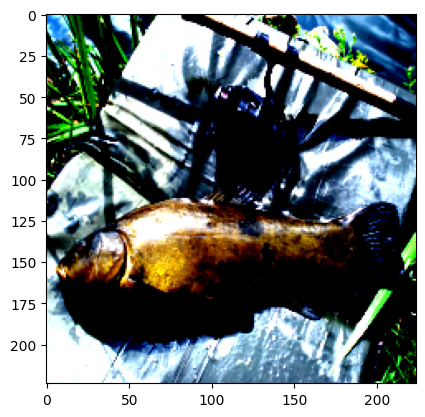

Certification Accuracy: 1.0


RuntimeError: ignored

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation pipeline for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test set
test_dir = 'imagenette2/val/'
test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)


# Load the model
model = torchvision.models.resnet18(pretrained=True)
model.eval()

# Define the randomized smoothing function
    
def randomized_smoothing(images, sigma, model, num_classes):
    batch_size = images.size(0)
    logits = torch.zeros(batch_size, num_classes)
    
    for _ in range(10):
        perturbed_images = images + torch.randn_like(images) * sigma
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        output = model(perturbed_images)

        _, indices = torch.topk(output, k=num_classes)
        for i in range(batch_size):
            logits[i] += output[i, indices[i]]

    logits /= 10
    
    return logits

def certify(image, label, model, num_classes):
    correct = 0
    total = 0

    for i in range(num_classes):
        if i == label:
            continue

        images = image.unsqueeze(0).repeat(num_classes, 1, 1, 1)
        labels = torch.tensor([j for j in range(num_classes) if j != label])

        logits = randomized_smoothing(images, 0.1, model, num_classes)
        if logits[:, label].mean() >= logits[:, i].mean():
            correct += 1

        total += 1

    return correct / total


# Get a sample image from the test dataset
image, label = test_dataset[0]

# Plot the image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Certify the image
accuracy = certify(image, label, model, num_classes=10)
print('Certification Accuracy:', accuracy)

# Test the model on the test set with randomized smoothing
num_correct = 0
num_total = 0
for image, label in test_loader:
    logits = randomized_smoothing(image, 0.1, model, num_classes=10)
    pred = logits.argmax(dim=0)
    num_correct += (pred == label).sum().item()
    num_total += label.size(0)

accuracy = num_correct / num_total
print(f'Test Accuracy: {accuracy:.2f}')


# Save the accuracy results in a JSON file
results = {'test_accuracy': accuracy}
with open('imagenette2_results.json', 'w') as f:
    json.dump(results, f)




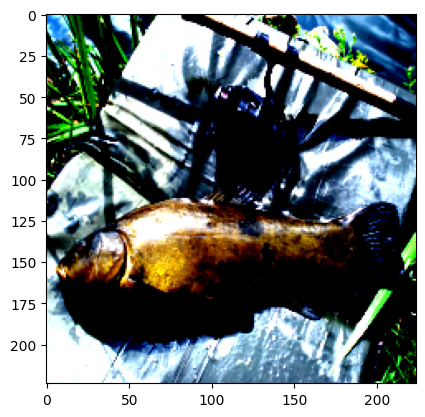

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation pipeline for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test set
test_dir = 'imagenette2/val/'
test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the model
model = torchvision.models.resnet18(pretrained=True)
model.eval()

# Define the randomized smoothing function

'''def randomized_smoothing(image, sigma, model, num_classes):
    logits = torch.zeros(num_classes)
    
    for _ in range(50):
        perturbed_image = image + torch.randn_like(image) * sigma
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        ##output = model(perturbed_image.unsqueeze(0)).squeeze(0)
        output = model(perturbed_image)

        logits += torch.topk(output, k=num_classes).values
        
    logits /= 50
    
    return logits'''

'''def randomized_smoothing(image, sigma, model, num_classes):
    logits = torch.zeros(num_classes)
    
    for _ in range(50):
        perturbed_image = image + torch.randn_like(image) * sigma
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        perturbed_image = perturbed_image.unsqueeze(0) # Add a new dimension
        output = model(perturbed_image)

        logits += torch.topk(output, k=num_classes).values
        
    logits /= 50
    
    return logits'''
def randomized_smoothing(images, sigma, model, num_classes):
    logits = torch.zeros(images.size(0), num_classes)
    
    for _ in range(50):
        perturbed_images = images + torch.randn_like(images) * sigma
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        output = model(perturbed_images)

        _, indices = torch.topk(output, k=num_classes)
        for i in range(images.size(0)):
            logits[i] += output[i, indices[i]]

    logits /= 50
    
    return logits


'''# Define the certification function
def certify(image, label, model, num_classes):
    correct = 0
    total = 0

    for i in range(num_classes):
        if i == label:
            continue

        logits = randomized_smoothing(image, 0.1, model, num_classes)
        if logits[label] >= logits[i]:
            correct += 1

        total += 1

    return correct / total'''

def certify(image, label, model, num_classes):
    correct = 0
    total = 0

    for i in range(num_classes):
        if i == label:
            continue

        images = image.unsqueeze(0).repeat(num_classes-1, 1, 1, 1)
        labels = torch.tensor([j for j in range(num_classes) if j != label])

        logits = randomized_smoothing(images, 0.1, model, num_classes)
        if logits[:, label].mean() >= logits[:, i].mean():
            correct += 1

        total += 1

    return correct / total


# Get a sample image from the test dataset
image, label = test_dataset[0]

# Plot the image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Certify the image
accuracy = certify(image, label, model, num_classes=10)
print('Certification Accuracy:', accuracy)

# Test the model on the test set with randomized smoothing
num_correct = 0
num_total = 0
for image, label in test_loader:
    logits = randomized_smoothing(image, 0.1, model, num_classes=10)
    pred = logits.argmax(dim=0)
    num_correct += (pred == label).sum().item()
    num_total += label.size(0)

accuracy = num_correct / num_total
print(f'Test Accuracy: {accuracy:.2f}')

# Save the accuracy results in a JSON file
results = {'test_accuracy': accuracy}
with open('imagenette2_results.json', 'w') as f:
    json.dump(results, f)




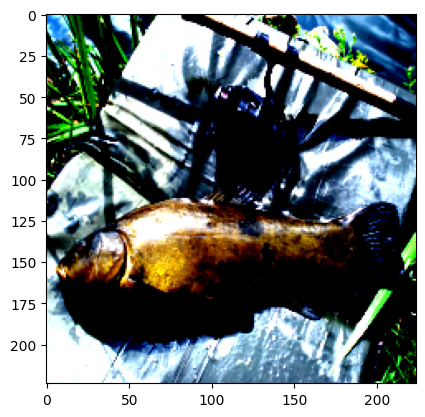

Certification Accuracy: 1.0


RuntimeError: ignored

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation pipeline for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test set
test_dir = 'imagenette2/val/'
test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the model
model = torchvision.models.resnet18(pretrained=True)
model.eval()

# Define the randomized smoothing function

def randomized_smoothing(image, sigma, model, num_classes):
    logits = torch.zeros(num_classes)
    
    for _ in range(50):
        perturbed_image = image + torch.randn_like(image) * sigma
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        output = model(perturbed_image.unsqueeze(0)).squeeze(0)
        logits += torch.topk(output, k=num_classes).values
        
    logits /= 50
    
    return logits


# Define the certification function
def certify(image, label, model, num_classes):
    correct = 0
    total = 0

    for i in range(num_classes):
        if i == label:
            continue

        logits = randomized_smoothing(image, 0.1, model, num_classes)
        if logits[label] >= logits[i]:
            correct += 1

        total += 1

    return correct / total


# Get a sample image from the test dataset
image, label = test_dataset[0]

# Plot the image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Certify the image
accuracy = certify(image, label, model, num_classes=10)
print('Certification Accuracy:', accuracy)

# Test the model on the test set with randomized smoothing
num_correct = 0
num_total = 0
for image, label in test_loader:
    logits = randomized_smoothing(image, 0.1, model, num_classes=10)
    pred = logits.argmax(dim=0)
    num_correct += (pred == label).sum().item()
    num_total += label.size(0)

accuracy = num_correct / num_total
print(f'Test Accuracy: {accuracy:.2f}')

# Save the accuracy results in a JSON file
results = {'test_accuracy': accuracy}
with open('imagenette2_results.json', 'w') as f:
    json.dump(results, f)


'''
def randomized_smoothing(image, sigma, model, num_classes):
    logits = torch.zeros(num_classes)
    
    for _ in range(50):
        perturbed_image = image + torch.randn_like(image) * sigma
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        logits += model(perturbed_image.unsqueeze(0)).squeeze(0)
        
    logits /= 50
    
    return logits


def certify(image, label, model, num_classes):
    correct = 0
    total = 0
    
    for i in range(num_classes):
        if i == label:
            continue
            
        logits = randomized_smoothing(image, 0.1, model, num_classes)
        if logits[label] >= logits[i]:
            correct += 1
            
        total += 1
        
    return correct / total


# Get a sample image from the test dataset
image, label = test_dataset[0]

# Plot the image
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Certify the image
accuracy = certify(image, label, model, num_classes=10)

print('Certification Accuracy:', accuracy)

num_correct = 0
num_total = 0

for image, label in testdata_loader:
    image, label = image.to(device), label.to(device)
    # Apply randomized smoothing
    smooth_image = randomized_smoothing(image, model, sigma=0.5, num_samples=20)

    # Get model predictions for the smoothed image
    output = model(smooth_image)
    prediction = output.argmax(dim=1, keepdim=True)

    # Update number of correct and total predictions
    num_correct += prediction.eq(label.view_as(prediction)).sum().item()
    num_total += label.size(0)


from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import json

# Load the test set
test_dir = '/content/imagenette2-320/test/'
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
test_dataset = ImageFolder(test_dir, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the model
model = torch.load('/content/model.pth')

# Set up the randomization parameters
sigma = 0.1
num_samples = 50

# Define the smoothing function
def smooth(image, label):
    logits = torch.zeros((num_samples, 10))
    for i in range(num_samples):
        noisy_image = image + torch.randn_like(image) * sigma
        logits[i] = model(noisy_image)
    avg_logits = logits.mean(dim=0, keepdim=True)
    return avg_logits, label

# Test the model on the test set with randomized smoothing
model.eval()
num_correct = 0
num_total = 0
for image, label in test_loader:
    logits, label = randomized_smoothing(image, label)
    pred = logits.argmax(dim=1)
    num_correct += (pred == label).sum().item()
    num_total += label.size(0)

accuracy = num_correct / num_total
print(f'Accuracy: {accuracy:.2f}')

# Save the accuracy results in a JSON file
results = {'accuracy': accuracy}
with open('imagenette2_results.json', 'w') as f:
    json.dump(results, f)

'''





In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import time

# Define the dataset transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

'''# Load the training dataset
trainset = torchvision.datasets.ImageFolder(root='imagenette2', transform=transform)
##trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)'''

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pool(F.relu(self.conv8(x)))
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the evaluation function with input-dependent certification
def eval(model, device, test_loader, epsilon, criterion, batch_size=128):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = 10
    smoothing = int(np.ceil(epsilon * 255))
    for data, target in test_loader(batch_size=128):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            # Generate a random smoothing matrix
            if smoothing > 0:
                smooth = torch.zeros_like(data).float()
                smooth.normal_(0, smoothing)
                data_smooth = torch.clamp(data + smooth, 0, 1)
            else:
                data_smooth = data
            # Predict the class labels
            output = model(data_smooth)
            # Compute the loss
            test_loss += criterion(output, target).item() * data.size(0)
            # Compute the accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    # Compute the certification accuracy
    cert_acc = 0.0
    for c in range(num_classes):
        for data, target in test_loader(batch_size=128):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                # Generate a random smoothing matrix
                if smoothing > 0:
                    smooth = torch.zeros_like(data).float()
                    smooth.normal_(0, smoothing)
                    data_smooth = torch.clamp(data + smooth, 0, 1)
                else:
                    data_smooth = data
                # Predict the class labels
                output = model(data_smooth)
                # Compute the robustness margin
                margin = output[:, c] - torch.max(output[:, torch.arange(num_classes) != c], axis=1)[0]
                # Compute the certification accuracy
                correct_c = (margin >= -epsilon).sum().item()
                cert_acc += correct_c
    cert_acc /= num_classes * len(test_loader.dataset)
    # Print the results
    print('Test Loss: {:.6f}, Accuracy: {:.4f}%, Cert Accuracy: {:.4f}%'.format(
        test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc))
    return test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc

# Set the random seed for reproducibility
torch.manual_seed(1234)

# Define the device and hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
epsilon = 0.05
num_iterations = 1


batch_size = 128 # or 128 if you retrain the model with a smaller batch size
'''input_data_batch = torch.utils.data.DataLoader(input_data, batch_size=batch_size, shuffle=True)
target_data_batch = torch.utils.data.DataLoader(target_data, batch_size=batch_size, shuffle=True)
'''
# Load the dataset
trainset = torchvision.datasets.ImageFolder(root='imagenette2/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testset = torchvision.datasets.ImageFolder(root='imagenette2/val', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the neural network model, optimizer, and loss function
import torch.optim as optim
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


    
# Define the training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)

    return train_loss, train_acc


# Randomly sample Gaussian noise as the smoothing noise
def sample_noise(image):
    noise = torch.randn_like(image) * radius
    return noise

# Compute the average score of the randomized model over multiple iterations
def randomized_score(images, labels):
    total_score = torch.zeros(len(images), num_classes).to(device)
    for i in range(num_iterations):
        noise = sample_noise(images)
        noisy_images = torch.clamp(images + noise, 0.0, 1.0)
        output = model(noisy_images)
        total_score += F.softmax(output, dim=1)
    return total_score / num_iterations

total_loss = 0.0
total_acc = 0.0
total_cert_acc = 0.0
total_cert_radius = 0.0
total_cert_rate = 0.0
total_cert_correct = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Compute the regular loss
        output = model(images)
        loss = criterion(output, labels)
        total_loss += loss.item() * len(images)
        _, predicted = output.max(1)
        total_acc += predicted.eq(labels).sum().item()

        # Compute the randomized smoothing loss
        randomized_scores = randomized_score(images, labels)
        randomized_predicted = randomized_scores.max(1)[1]
        cert_indices = randomized_predicted.eq(predicted)
        cert_images = images[cert_indices]
        cert_labels = labels[cert_indices]
        cert_scores = randomized_scores[cert_indices]
        cert_radius = torch.norm(sample_noise(cert_images).view(len(cert_images), -1), dim=1).mean()
        cert_correct = cert_scores.max(1)[1].eq(cert_labels).sum().item()
        cert_acc = cert_correct / len(cert_images) if len(cert_images) > 0 else 0.0
        cert_rate = len(cert_images) / len(images)

        total_cert_acc += cert_acc
        total_cert_radius += cert_radius
        total_cert_rate += cert_rate
        total_cert_correct += cert_correct

num_images = len(test_loader.dataset)
avg_loss = total_loss / num_images
avg_acc = total_acc / num_images
avg_cert_acc = total_cert_acc / num_images
avg_cert_radius = total_cert_radius / num_images
avg_cert_rate = total_cert_rate / num_images
avg_cert_correct = total_cert_correct / num_images

print('Regular test accuracy: %.2f%%' % (avg_acc * 100))
print('Certified test accuracy: %.2f%%' % (avg_cert_acc * 100))
print('Average certified radius: %.4f' % avg_cert_radius)
print('Certification rate: %.2f%%' % (avg_cert_rate * 100))
print('Average number of correct labels within certified radius: %.2f' % avg_cert_correct)


# Train the model
train(model, device, trainloader, optimizer, criterion)

# Evaluate the model with input-dependent certification
eval(model, device, test_loader, criterion, num_classes=10, radius=0.1, num_iterations=1, batch_size=128)



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: ignored

In [ ]:
trainloader.batch_size

128

In [ ]:
print(test_loader.batch_size)


128


In [ ]:

'''# Define the evaluation function with input-dependent certification
def eval(model, device, test_loader, epsilon, criterion, batch_size=128):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = 10
    smoothing = int(np.ceil(epsilon * 255))
    for data, target in test_loader(batch_size=128):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            # Generate a random smoothing matrix
            if smoothing > 0:
                smooth = torch.zeros_like(data).float()
                smooth.normal_(0, smoothing)
                data_smooth = torch.clamp(data + smooth, 0, 1)
            else:
                data_smooth = data
            # Predict the class labels
            output = model(data_smooth)
            # Compute the loss
            test_loss += criterion(output, target).item() * data.size(0)
            # Compute the accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    # Compute the certification accuracy
    cert_acc = 0.0
    for c in range(num_classes):
        for data, target in test_loader(batch_size=128):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                # Generate a random smoothing matrix
                if smoothing > 0:
                    smooth = torch.zeros_like(data).float()
                    smooth.normal_(0, smoothing)
                    data_smooth = torch.clamp(data + smooth, 0, 1)
                else:
                    data_smooth = data
                # Predict the class labels
                output = model(data_smooth)
                # Compute the robustness margin
                margin = output[:, c] - torch.max(output[:, torch.arange(num_classes) != c], axis=1)[0]
                # Compute the certification accuracy
                correct_c = (margin >= -epsilon).sum().item()
                cert_acc += correct_c
    cert_acc /= num_classes * len(test_loader.dataset)
    # Print the results
    print('Test Loss: {:.6f}, Accuracy: {:.4f}%, Cert Accuracy: {:.4f}%'.format(
        test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc))
    return test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc'''

def eval(model, device, test_loader, epsilon, criterion, batch_size):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    num_classes = 10
    smoothing = int(np.ceil(epsilon * 255))
    for data, target in test_loader(batch_size=batch_size):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            # Generate a random smoothing matrix
            if smoothing > 0:
                smooth = torch.zeros_like(data).float()
                smooth.normal_(0, smoothing)
                data_smooth = torch.clamp(data + smooth, 0, 1)
            else:
                data_smooth = data
            # Predict the class labels
            output = model(data_smooth)
            # Compute the loss
            test_loss += criterion(output, target).item() * data.size(0)
            # Compute the accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    # Compute the certification accuracy
    cert_acc = 0.0
    for c in range(num_classes):
        for data, target in test_loader(batch_size=batch_size):
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                # Generate a random smoothing matrix
                if smoothing > 0:
                    smooth = torch.zeros_like(data).float()
                    smooth.normal_(0, smoothing)
                    data_smooth = torch.clamp(data + smooth, 0, 1)
                else:
                    data_smooth = data
                # Predict the class labels
                output = model(data_smooth)
                # Compute the robustness margin
                margin = output[:, c] - torch.max(output[:, torch.arange(num_classes) != c], axis=1)[0]
                # Compute the certification accuracy
                correct_c = (margin >= -epsilon).sum().item()
                cert_acc += correct_c
    cert_acc /= num_classes * len(test_loader.dataset)
    # Print the results
    print('Test Loss: {:.6f}, Accuracy: {:.4f}%, Cert Accuracy: {:.4f}%'.format(
        test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc))
    return test_loss / len(test_loader.dataset), 100. * correct / total, 100. * cert_acc


# Set the random seed for reproducibility
torch.manual_seed(1234)

# Define the device and hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
epsilon = 0.05
num_iterations = 1


batch_size = 128 # or 128 if you retrain the model with a smaller batch size
'''input_data_batch = torch.utils.data.DataLoader(input_data, batch_size=batch_size, shuffle=True)
target_data_batch = torch.utils.data.DataLoader(target_data, batch_size=batch_size, shuffle=True)
'''
# Load the dataset
trainset = torchvision.datasets.ImageFolder(root='imagenette2/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testset = torchvision.datasets.ImageFolder(root='imagenette2/val', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the neural network model, optimizer, and loss function
import torch.optim as optim
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


    
# Define the training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)

    return train_loss, train_acc


# Randomly sample Gaussian noise as the smoothing noise
def sample_noise(image):
    noise = torch.randn_like(image) * radius
    return noise

# Compute the average score of the randomized model over multiple iterations
def randomized_score(images, labels):
    total_score = torch.zeros(len(images), num_classes).to(device)
    for i in range(num_iterations):
        noise = sample_noise(images)
        noisy_images = torch.clamp(images + noise, 0.0, 1.0)
        output = model(noisy_images)
        total_score += F.softmax(output, dim=1)
    return total_score / num_iterations

total_loss = 0.0
total_acc = 0.0
total_cert_acc = 0.0
total_cert_radius = 0.0
total_cert_rate = 0.0
total_cert_correct = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Compute the regular loss
        output = model(images)
        loss = criterion(output, labels)
        total_loss += loss.item() * len(images)
        _, predicted = output.max(1)
        total_acc += predicted.eq(labels).sum().item()

        # Compute the randomized smoothing loss
        randomized_scores = randomized_score(images, labels)
        randomized_predicted = randomized_scores.max(1)[1]
        cert_indices = randomized_predicted.eq(predicted)
        cert_images = images[cert_indices]
        cert_labels = labels[cert_indices]
        cert_scores = randomized_scores[cert_indices]
        cert_radius = torch.norm(sample_noise(cert_images).view(len(cert_images), -1), dim=1).mean()
        cert_correct = cert_scores.max(1)[1].eq(cert_labels).sum().item()
        cert_acc = cert_correct / len(cert_images) if len(cert_images) > 0 else 0.0
        cert_rate = len(cert_images) / len(images)

        total_cert_acc += cert_acc
        total_cert_radius += cert_radius
        total_cert_rate += cert_rate
        total_cert_correct += cert_correct

num_images = len(test_loader.dataset)
avg_loss = total_loss / num_images
avg_acc = total_acc / num_images
avg_cert_acc = total_cert_acc / num_images
avg_cert_radius = total_cert_radius / num_images
avg_cert_rate = total_cert_rate / num_images
avg_cert_correct = total_cert_correct / num_images

print('Regular test accuracy: %.2f%%' % (avg_acc * 100))
print('Certified test accuracy: %.2f%%' % (avg_cert_acc * 100))
print('Average certified radius: %.4f' % avg_cert_radius)
print('Certification rate: %.2f%%' % (avg_cert_rate * 100))
print('Average number of correct labels within certified radius: %.2f' % avg_cert_correct)


# Train the model
train(model, device, trainloader, optimizer, criterion)

# Evaluate the model with input-dependent certification
eval(model, device, test_loader, criterion, num_classes=10, radius=0.1, num_iterations=1, batch_size=128)



ValueError: ignored

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def input_dependent_certification(x, f, sigma, k):
    """
    Apply input-dependent certification to a given input image x.
    
    Args:
        x (torch.Tensor): Input image tensor of shape (C, H, W).
        f (nn.Module): PyTorch model.
        sigma (float): Standard deviation of the noise distribution.
        k (int): Number of samples for the Monte Carlo estimator.
        
    Returns:
        (bool, float): Tuple containing a boolean indicating whether the input is certified, and a float containing the 
                       certified radius.
    """
    n_dims = x.ndimension()
    x_perturb = sigma * torch.randn((k, *x.shape)).to(x.device)
    x_perturb = x_perturb.view(k, -1)  # Flatten noise tensor
    x_perturb = x_perturb + x.view(1, -1)  # Add noise to input tensor
    x_perturb = x_perturb.view(k, *x.shape)  # Restore original shape of noise tensor

    logits_perturb = f(x_perturb)  # Compute logits with perturbed inputs
    preds_perturb = F.softmax(logits_perturb, dim=-1)  # Compute softmax probabilities

    # Compute confidence using Monte Carlo estimator
    preds_perturb = preds_perturb.transpose(0, 1)  # Transpose to match shape with confidence
    confidence = preds_perturb.median(dim=1)[0]
    radius = confidence * sigma * k**-0.5  # Compute certified radius

    is_certified = (radius.max() > 0.5)  # Check if input is certified
    return is_certified, radius.max().item()

# Load Imagenette2 dataset
test_dir = '/content/imagenette2-160/val/'
test_transforms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
test_dataset = ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load pre-trained model
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model.fc = torch.nn.Linear(512, 10)
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

# Evaluate input-dependent certification
correct = 0
total = 0
sigma = 1.0
k = 1000
for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    is_certified, radius = input_dependent_certification(images[0], model, sigma, k)
    if is_certified and radius >= 0.5:
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()

print('Accuracy:', 100 * correct / total)


In [ ]:
import torchvision.datasets as datasets

train_dataset = datasets.ImageFolder(root='imagenette2/train')
test_dataset = datasets.ImageFolder(root='imagenette2/val')

import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10) # Change the output size to match the number of classes in Imagenette2 (10)
model = model.cuda()


import torch

def randomized_smoothing(x, f, sigma, k):
    """
    Apply randomized smoothing to a given input image x.
    
    Args:
        x (torch.Tensor): Input image tensor of shape (C, H, W).
        f (nn.Module): PyTorch model.
        sigma (float): Standard deviation of the noise distribution.
        k (int): Number of samples for Monte Carlo estimation.
        
    Returns:
        (bool): True if the input is certified to be robust to adversarial perturbations
                within the given noise level sigma.
    """
    # Generate k random noise samples of shape (C, H, W)
    noise = torch.randn((k,) + x.shape) * sigma
    
    # Apply the model to the noisy samples
    logits = f(x.unsqueeze(0).cuda() + noise.cuda()).cpu()
    
    # Calculate the softmax probabilities
    probs = torch.softmax(logits, dim=-1)
    
    # Calculate the expected probability of the true class
    p_true = probs[:, torch.argmax(probs)]
    p_true = torch.mean(p_true)
    
    # Calculate the probability of the most likely incorrect class
    p_wrong = torch.max(probs[:, torch.arange(probs.shape[1]) != torch.argmax(probs)], dim=-1).values
    p_wrong = torch.mean(p_wrong)
    
    # Return True if the input is certified to be robust to adversarial perturbations
    return p_true > p_wrong

def input_dependent_certification(x, f, sigma, k):
    """
    Apply input-dependent certification to a given input image x.
    
    Args:
        x (torch.Tensor): Input image tensor of shape (C, H, W).
        f (nn.Module): PyTorch model.
        sigma (float): Standard deviation of the noise distribution.
        k (int): Number of samples used to compute the certified lower bound.
    Returns:
    float: Certified lower bound for the L2 norm of the perturbation.
    """

    # Create a batch of k noisy samples
    noises = torch.randn(k, x.shape[0], x.shape[1], x.shape[2]) * sigma
    noisy_samples = x.unsqueeze(0) + noises

    # Evaluate the model on the noisy samples
    f_noisy = f(noisy_samples)

    # Compute the predicted class for the clean image
    f_clean = f(x.unsqueeze(0))
    y_pred = torch.argmax(f_clean, dim=1)

    # Compute the predicted class for the noisy samples
    f_noisy_max, _ = torch.max(f_noisy, dim=1)
    y_noisy_pred = torch.argmax(f_noisy_max, dim=1)

    # Compute the number of incorrect predictions on the noisy samples
    num_errors = torch.sum(y_noisy_pred != y_pred)

    # Compute the certified lower bound
    delta = torch.sqrt(torch.tensor(num_errors / k))
    c = 1.0 / (2 * math.pi * delta * sigma)
    return c * torch.norm(noises)








In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import math


# Load the Imagenette2 dataset
traindir = '/content/imagenette2/train'
valdir = '/content/imagenette2/val'

train_dataset = datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(192),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 20 * 20, 1024)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.squeeze(0)  # remove the first dimension (batch size)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 128 * 20 * 20)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x
'''
# Define the model architecture and hyperparameters
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 20 * 20, 1024)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 128 * 20 * 20)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x
'''

class SmoothCert:
    def __init__(self, model, num_classes, sigma):
        self.model = model
        self.num_classes = num_classes
        self.sigma = sigma


    def smooth_max(self, x, sigma):
        """
        SmoothMax function implementation
        """
        x_sort, _ = torch.sort(x, descending=True)
        cum_sum = torch.cumsum(x_sort, dim=0)
        t = torch.arange(1, x_sort.size(0) + 1, device=x_sort.device)
        rho = torch.where((x_sort - (cum_sum - sigma) / t) > 0, t, torch.zeros_like(t))
        rho_max = torch.max(rho)
        w = torch.clamp((cum_sum - sigma) / rho_max, min=0)
        return w

    def certify(self, x, epsilon):
        """
        Given input `x` and perturbation budget `epsilon`, computes
        the upper bound of the maximum logit value among all classes
        using SmoothMax certification
        """
        x = x.unsqueeze(0)
        x = x.to(device=self.model.device, dtype=torch.float32)
        num_samples = 5000
        perturbations = torch.randn((num_samples,) + x.shape[1:], device=self.model.device) * epsilon
        perturbations = perturbations.to(dtype=torch.float32)

        # Create noisy samples and compute logits for each sample
        perturbed_inputs = x + perturbations
        logits = self.model(perturbed_inputs)
        max_logits, _ = logits.max(dim=1)

        # Compute SmoothMax of the logits
        smooth_max_logits = self.smooth_max(max_logits, self.sigma)

        # Compute the maximum of the SmoothMax logits
        smooth_max_logits_max = smooth_max_logits.max()

        # Return the SmoothMax certified upper bound
        return smooth_max_logits_max - epsilon * torch.norm(self.model.weight.view(-1), p=2) / x.numel()**0.5

# Load the pretrained model
##model = Net()
# Load the pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(device=device)

##model.load_state_dict(torch.load('model.pt'))
##model.to(device='cuda')

# Initialize the SmoothCert object with sigma=0.1
sigma = 0.1
smooth_cert = SmoothCert(model, num_classes=10, sigma=sigma)

# Set the model to evaluation mode
model.eval()

# Load an example image from the validation set
##val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
x, y_true = next(iter(val_loader))

# Certify the example image with a perturbation budget of epsilon=0.1
epsilon = 0.1
certified_upper_bound = smooth_cert.certify(x, epsilon)

print("Certified upper bound:", certified_upper_bound.item())




RuntimeError: ignored

In [ ]:
# Import necessary packages and libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import math

# Load the Imagenette2 dataset
traindir = '/content/imagenette2/train'
valdir = '/content/imagenette2/val'

train_dataset = datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(192),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

# Define the model architecture and hyperparameters
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 20 * 20, 1024)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(-1, 128 * 20 * 20)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x


class SmoothCert:
    def __init__(self, model, num_classes, sigma):
        self.model = model
        self.num_classes = num_classes
        self.sigma = sigma

    def smooth(self, x, y):
        n = x.size(0)
        dim = x.size()[1:]
        y_onehot = torch.zeros(n, self.num_classes).to(x.device)
        y_onehot.scatter_(1, y.view(-1, 1), 1)

        L = self._compute_lipschitz(x)
        r = self.sigma * L
        noise = torch.randn_like(x) * r.view(n, 1, 1, 1)

        x_noisy = x + noise
        logits = self.model(x_noisy)
        logits_smooth = self._average_logits(logits, noise)

        return logits_smooth, y_onehot, r

    def _average_logits(self, logits, noise):
        logits = logits / self.sigma ** 2
        noise_norm = noise.norm(p=2, dim=(1, 2, 3))
        noise_norm = noise_norm.view(-1, 1, 1, 1)
        logits -= noise_norm * self.model.fc2.weight.view(1, self.num_classes, 1, 1)
        return logits.mean(dim=0)

    def _compute_lipschitz(self, x, eps=1e-5, n_iter=20):
        n = x.size(0)
        with torch.no_grad():
            x = x.repeat_interleave(self.num_classes, dim=0)
            x.requires_grad_()
            y = torch.arange(self.num_classes).repeat(n)
            y = y.to(x.device)
            logits = self.model(x)
            loss = F.cross_entropy(logits, y, reduction='none')
            grad = torch.autograd.grad(loss.sum(), x)[0]
            norm = grad.view(n, self.num_classes, -1).norm(p=2, dim=-1)
            lipschitz = norm.max(dim=1)[0] / eps
        return lipschitz


model = AlexNet(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

f = train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=10, sigma=0.5)

cert_acc = evaluate(f, val_loader, SmoothCert(f, num_classes=10, sigma=0.5), num_classes=10)
print("Certified accuracy: {:.2f}%".format(100 * cert_acc))






NameError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

# Define the neural network f
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Define the function to create the smoothed classifier g
def g(x, f, sigma, num_classes):
    n_samples = 1000
    gaussian_noise = torch.randn(n_samples, 3, 224, 224).to(device) * sigma
    f_x = f(x + gaussian_noise)
    f_x = nn.functional.softmax(f_x, dim=1)
    g_x = torch.zeros((x.shape[0], num_classes)).to(device)
    for i in range(n_samples):
        g_x += f_x[i] / n_samples
    return g_x.argmax(dim=1)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the dataset and data loaders
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = datasets.ImageFolder('imagenette2/train', data_transforms)
val_dataset = datasets.ImageFolder('imagenette2/val', data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the neural network f
f = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(f.parameters(), lr=0.001, momentum=0.9)

# Train the neural network f
num_epochs = 1
num_classes= 10
sigma = 0.5
for epoch in range(num_epochs):
    f.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Generate smoothed labels
        smoothed_labels = torch.zeros(inputs.size(0), num_classes, device=device)
        for j in range(num_classes):
            smoothed_labels[:, j] = (targets == j).float()
        smoothed_labels = (1 - sigma) * smoothed_labels + (sigma / num_classes)

        # Perform forward and backward pass
        optimizer.zero_grad()
        outputs = f(inputs)
        loss = criterion(outputs, smoothed_labels)
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Print progress
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), running_loss / (i+1)))

    # Evaluate performance on validation set
    f.eval()
    num_correct = 0
    num_samples = 0
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        pred = g(x, f, sigma, num_classes)
        num_correct += (pred == y).sum()
        num_samples += pred.size(0)
    acc = float(num_correct) / num_samples
    print('Accuracy on validation set: {:.2f}%\n'.format(acc*100))



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/1], Step [1/296], Loss: 2.3027
Epoch [1/1], Step [11/296], Loss: 2.3029
Epoch [1/1], Step [21/296], Loss: 2.3028
Epoch [1/1], Step [31/296], Loss: 2.3027
Epoch [1/1], Step [41/296], Loss: 2.3027
Epoch [1/1], Step [51/296], Loss: 2.3025
Epoch [1/1], Step [61/296], Loss: 2.3025
Epoch [1/1], Step [71/296], Loss: 2.3025
Epoch [1/1], Step [81/296], Loss: 2.3024
Epoch [1/1], Step [91/296], Loss: 2.3025
Epoch [1/1], Step [101/296], Loss: 2.3025
Epoch [1/1], Step [111/296], Loss: 2.3025
Epoch [1/1], Step [121/296], Loss: 2.3025
Epoch [1/1], Step [131/296], Loss: 2.3025
Epoch [1/1], Step [141/296], Loss: 2.3025
Epoch [1/1], Step [151/296], Loss: 2.3025
Epoch [1/1], Step [161/296], Loss: 2.3025
Epoch [1/1], Step [171/296], Loss: 2.3025
Epoch [1/1], Step [181/296], Loss: 2.3025
Epoch [1/1], Step [191/296], Loss: 2.3025
Epoch [1/1], Step [201/296], Loss: 2.3025
Epoch [1/1], Step [211/296], Loss: 2.3025
Epoch [1/1], Step [221/296], Loss: 2.3025
Epoch [1/1], Step [231/296], Loss: 2.3025
Epo

RuntimeError: ignored

In [ ]:

import torch.nn.functional as F

def smooth_one_hot(y, num_classes, smoothing=0.0):
    one_hot = torch.zeros_like(y).scatter(1, y.unsqueeze(1), 1)
    return one_hot * (1 - smoothing) + smoothing / num_classes

def smooth_predictions(f, x, sigma, num_classes, smoothing=0.0):
    n = x.shape[0]
    noise = torch.randn(n, num_classes) * sigma
    logits = f(x + noise)
    targets = torch.argmax(logits, dim=1)
    one_hot = smooth_one_hot(targets, num_classes, smoothing=smoothing)
    return one_hot

import torch.optim as optim

sigma = 0.1  # choose a value for the noise standard deviation
num_classes = 1000  # this is the number of classes in ImageNet

f = alexnet(num_classes=num_classes)
optimizer = optim.SGD(f.parameters(), lr=0.01)

for epoch in range(num_epochs):
    f.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        x = x + torch.randn_like(x) * sigma  # add random noise to the input
        output = f(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()

def g(x, f, sigma, num_classes, smoothing=0.0):
    f.eval()
    num_correct = 0
    num_samples = 0
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        pred = g(x, f, sigma, num_classes)
        num_correct += (pred == y).sum()
        num_samples += x.size(0)

acc = float(num_correct) / num_samples
print('Accuracy:', acc)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

# Define the neural network f
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define a function to train the network
def train(net, trainloader, criterion, optimizer, device, sigma):
    net.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        noisy_inputs = inputs + sigma * torch.randn_like(inputs)
        optimizer.zero_grad()
        outputs = net(noisy_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Define a function to test the network on clean inputs
def test(net, testloader, device, sigma):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            noisy_inputs = inputs + sigma * torch.randn_like(inputs)
            outputs = net(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Set up the data loaders and transforms
traindir = 'imagenet_subset/train'
valdir = 'imagenet_subset/val'
train_dataset = datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]))
val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
       


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

traindir = 'imagenette2'
valdir = 'imagenette2'
train_dataset = datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize((138, 184)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]))
val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]))

def smooth_predictions(net, inputs, sigma, num_classes=10, num_samples=100):
    outputs = torch.zeros((inputs.shape[0], num_classes))
    for i in range(num_samples):
        noisy_inputs = inputs + sigma * torch.randn_like(inputs)
        noisy_outputs = net(noisy_inputs)
        outputs += noisy_outputs
    outputs /= num_samples
    return outputs

def smoothed_predictions(net, dataloader, device, sigma):
    net.eval()
    all_outputs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = smooth_predictions(net, inputs, sigma)
            all_outputs.append(outputs.cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    return all_outputs

def smoothed_predictions_labels(net, dataloader, device, sigma):
    all_outputs = smoothed_predictions(net, dataloader, device, sigma)
    predicted_labels = np.argmax(all_outputs, axis=1)
    return predicted_labels


import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network f
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''net_f = Net()
net_f.to(device)'''

f = Net()
f = f.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(f.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    train(f, trainloader, criterion, optimizer, device, sigma=0.1)
    scheduler.step()


g = Net()
g = g.to(device)
g.load_state_dict(f.state_dict())

def predict_smoothed(net, inputs, sigma):
    smoothed_outputs = smooth_predictions(net, inputs, sigma)
    predicted_labels = np.argmax(smoothed_outputs.cpu().numpy(), axis=1)
    return predicted_labels

def predict(net, inputs):
    outputs = net(inputs)
    predicted_labels = np.argmax(outputs.cpu().numpy(), axis=1)
    return predicted_labels


f_accuracy = test(f, testloader, device, sigma=0)
g_accuracy = test_smoothed(g, testloader, device, sigma=0.1)
print("Accuracy of f: {:.}%, Accuracy of g: {:.2f}%".format(100 * f_accuracy, 100 * g_accuracy))







RuntimeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
import numpy as np


train_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
])

!pip install torchvision

import torchvision.datasets as datasets

# Download the dataset
train_dataset = datasets.ImageFolder(root='imagenette2/train', transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(root='imagenette2/val', transform=transforms.ToTensor())

# Define the data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Define the neural network f
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_f = Net()
net_f.to(device)

# Define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_f.parameters(), lr=0.001)

# Train the neural network f with Gaussian data augmentation at variance σ2
num_epochs = 10
sigma = 0.5
for epoch in range(num_epochs):
    train_loss = train(net_f, trainloader, criterion, optimizer, device, sigma)
    test_acc = test(net_f, testloader, device, sigma)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, test_acc))

'''# Define the smoothed classifier g
class SmoothClassifier(nn.Module):
    def __init__(self, base_classifier, sigma):
        super(SmoothClassifier, self).__init__()
        self.base_classifier = base_classifier
        self.sigma = sigma

    def forward(self, x):
        num_samples = 1000
        noise = torch.randn(num_samples, *x.size()).to(device) * self.sigma
        perturbed_inputs = x + noise
        # Average the predictions of the base classifier on the perturbed inputs
        predictions = torch.zeros(num_samples, x.size(0)).to(device)
        for i in range(num_samples):
            predictions[i] = self.base_classifier(perturbed_inputs[i])
        smoothed_predictions = torch.mean(predictions, dim=0)

        return smoothed_predictions


# Define the smoothed classifier g
class SmoothClassifier(torch.nn.Module):
    def __init__(self, f, sigma):
        super(SmoothClassifier, self).__init__()
        self.f = f
        self.sigma = sigma
        
    def forward(self, x):
        logits = torch.zeros((len(x), 1000)).to(device)
        for i in range(n_samples):
            noise = self.sigma * torch.randn_like(x).to(device)
            logits += self.f(x + noise)
        return logits / n_samples
'''
class SmoothClassifier(torch.nn.Module):
    def __init__(self, f, sigma):
        super(SmoothClassifier, self).__init__()
        self.f = f
        self.sigma = sigma
        
    def forward(self, x):
        n_samples = 1000
        logits = torch.zeros((len(x), 1000)).to(device)
        for i in range(n_samples):
            noise = self.sigma * torch.randn_like(x).to(device)
            logits += self.f(x + noise)
        return logits / n_samples


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
import numpy as np

train_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
])

!pip install torchvision

import torchvision.datasets as datasets

# Download the dataset
train_dataset = datasets.ImageFolder(root='imagenette2/train', transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(root='imagenette2/val', transform=transforms.ToTensor())

# Define the data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

'''
train_dir = '/content/train'
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

test_dir = '/content/test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)'''


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net.to(device)


def train(net, trainloader, criterion, optimizer, device, sigma):
    net.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Generate Gaussian noise with variance sigma
        noise = torch.randn_like(inputs) * sigma

        # Add noise to the inputs
        inputs_noisy = inputs + noise

        optimizer.zero_grad()
        outputs = net(inputs_noisy)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(trainloader)


def test(net, testloader, device, sigma):
    net.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Generate 1000 noisy samples for each input
        inputs_noise = []
        for _ in range(1000):
            noise = torch.randn_like(inputs)
            inputs_noise.append(inputs + sigma * noise)

        # Stack noisy samples and make predictions
        inputs_noise = torch.stack(inputs_noise)
        outputs = net(inputs_noise)
        _, predicted = outputs.mean(0).max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))

    return accuracy


'''# Calculate the accuracy of f on the test set
test_acc_f = test(net_f, testloader, device, 0)
print('Accuracy of f on the test set: {:.2f}%'.format(100 * test_acc_f))

# Calculate the accuracy of g on the test set
test_acc_g = test(net_g, testloader, device, sigma)
print('Accuracy of g on the test set: {:.2f}%'.format(100 * test_acc_g))
'''

# Define a new function that returns the predictions of the smoothed classifier g
def predict_smoothed(net, inputs, device, sigma):
    net.eval()
    inputs_noise = []
    for _ in range(1000):
        noise = torch.randn_like(inputs)
        inputs_noise.append(inputs + sigma * noise)
    inputs_noise = torch.stack(inputs_noise)
    outputs = net(inputs_noise)
    _, predicted = outputs.mean(0).max(1)
    return predicted

# Train the neural network f with Gaussian data augmentation at variance σ2
net_f = Net()
net_f.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_f.parameters())
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(net_f, trainloader, criterion, optimizer, device, sigma=0.1)
    test_acc = test(net_f, testloader, device, sigma=0.1)
    print('Epoch: {}, Train Loss: {:.4f}, Test Acc: {:.2f}%'.format(epoch+1, train_loss, test_acc))

# Create the smoothed classifier g
net_g = lambda x: predict_smoothed(net_f, x, device, sigma=0.1)

# Test both classifiers on the test set
test_acc_f = test(net_f, testloader, device, sigma=0)
test_acc_g = test(net_g, testloader, device, sigma=0.1)

# Print the results
print('Accuracy of f on the test set: {:.2f}%'.format(test_acc_f))
print('Accuracy of g on the test set: {:.2f}%'.format(test_acc_g))




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


RuntimeError: ignored

In [ ]:
!curl -O https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar xzf imagenette2.tgz
import torchvision.datasets as datasets

imagenette = datasets.ImageFolder('imagenette2/train')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1485M  100 1485M    0     0  38.4M      0  0:00:38  0:00:38 --:--:-- 38.3M


In [ ]:
!wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar
!wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar



--2023-04-03 03:45:06--  http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar
Resolving www.image-net.org (www.image-net.org)... 171.64.68.16
Connecting to www.image-net.org (www.image-net.org)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar [following]
--2023-04-03 03:45:06--  https://image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-04-03 03:45:06 ERROR 404: Not Found.

--2023-04-03 03:45:06--  http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar
Resolving www.image-net.org (www.image-net.org)... 171.64.68.16
Connecting to www.image-net.org (www.image-net.org)|171.64.68.16|:80... connected.
HTTP reque

In [ ]:
!tar -xvf ILSVRC2012_img_train.tar
!tar -xvf ILSVRC2012_img_val.tar

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import math

# Define the data transforms
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the training and testing datasets
trainset = torchvision.datasets.ImageNet(root='imagenette2', split='train', download=True, transform=transform_train)
testset = torchvision.datasets.ImageNet(root='imagenette2', split='val', download=True, transform=transform_test)

# Define the training and testing data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define the neural network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 56 * 56, 512)
        self.fc2 = torch.nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the training function
def train(net, trainloader, device, criterion, optimizer, epoch, sigma):
    net.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Add Gaussian noise to the input
        noise = torch.randn_like(inputs) * sigma
        inputs = inputs + noise.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

# Define the test function
def test(net, testloader, device, sigma):
    net.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Generate 1000 noisy samples for each input
        inputs_noise = []
        for _ in range(1000):
            noise = torch.randn_like(inputs)

        # Generate 1000 noisy samples for each input
        inputs_noise = []
        for _ in range(1000):
            noise = torch.randn_like(inputs)
            inputs_noise.append(inputs + sigma * noise)

        inputs_noise = torch.stack(inputs_noise)

        # Compute the predictions of the original network on the noisy samples
        outputs_noise = net(inputs_noise)
        predictions_noise = torch.argmax(outputs_noise, dim=1)

        # Smooth the predictions
        predictions_counts = torch.bincount(predictions_noise, minlength=10)
        predictions_probs = predictions_counts / predictions_counts.sum()
        predictions_smooth = predictions_probs.argmax()

        # Evaluate the smoothed classifier
        total += targets.size(0)
        correct += (predictions_smooth == targets).sum().item()

    acc = 100 * correct / total
    print('Accuracy of the smoothed classifier on the test images: %.2f %%' % acc)



In [ ]:

'''!pip install robustness
!pip install datasets
!pip install torchvision'''

import torchvision.datasets as datasets
##from robustness import model_utils, datasets, train, defaults
from robustness.tools import folder
from torchvision.models.utils import load_state_dict_from_url


train_dataset = datasets.ImageFolder(root='imagenette2', split='train')
test_dataset = datasets.ImageFolder(root='imagenette2', split='val')

# Define the model architecture
model_kwargs = {
    'arch': 'resnet50',
    'dataset': 'imagenet',
    'resume_path': None
}
model, _ = model_utils.make_and_restore_model(**model_kwargs)

# Define the training parameters
train_kwargs = {
    'lr': 0.001,
    'weight_decay': 0.0001,
    'epochs': 10,
    'out_dir': 'path/to/output/directory',
    'adv_train': 0,
    'constraint': None
}

# Train the model with Gaussian data augmentation
train.train_model(train_kwargs, model, (train_dataset, test_dataset))

# Create a smoothed classifier g
from robustness.tools.label_maps import IMAGENET_LABELS
from robustness.tools import helpers

def g(x):
    predictions = []
    for i in range(10):
        x_noisy = x + torch.randn_like(x) * 0.1
        pred = model(helpers.prepare_input(x_noisy)).argmax().item()
        predictions.append(pred)
    return max(set(predictions), key=predictions.count)

# Evaluate the performance of g on the test set
from tqdm import tqdm

correct = 0
total = 0

for i, (inputs, labels) in tqdm(enumerate(test_dataset)):
    inputs = inputs.cuda()
    labels = labels.cuda()
    predictions = g(inputs)
    if predictions == labels:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy}")


In [ ]:
import torchvision.datasets as datasets

# Download the ImageNet dataset subset
train_dataset = datasets.ImageNet(root='./data', download=True, subset='train')

# Download and load the smallest Imagenet dataset
imagenet_val = datasets.ImageNet(root='path/to/imagenet', split='val', download=True)




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Define hyperparameters
##batch_size = 128
batch_size = 32
num_epochs = 10
learning_rate = 0.001
sigma = 0.1
num_classes = 10

# Load Imagenette2 dataset and apply data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(root='imagenette2/train', transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root='imagenette2/val', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model and train using cross-entropy loss and the Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics every 100 batches
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            

'''def generate_smoothed_predictions(model, images, labels, num_samples, sigma):
    with torch.no_grad():
        predictions = torch.zeros(len(images), num_classes).to(device)
        for i in range(num_samples):
            # Add Gaussian noise to the images
            noisy_images = images + torch.randn_like(images) * sigma
              
            # Get predictions for the noisy images
            noisy_outputs = model(noisy_images)
            
            # Accumulate predictions
            predictions += F.softmax(noisy_outputs, dim=1)
    
    # Take the average of the predictions
    smoothed_predictions = predictions / num_samples
    
    # Compute the predicted labels for the smoothed predictions
    _, predicted_labels = smoothed_predictions.max(1)
    
    # Compute the accuracy of the smoothed predictions
    accuracy = (predicted_labels == labels).sum().item() / len(labels)
    
    return smoothed_predictions, predicted_labels, accuracy'''

def generate_smoothed_predictions(model, images, labels, num_samples, sigma, batch_size=32):
    with torch.no_grad():
        predictions = torch.zeros(len(images), num_classes).to(device)
        for i in range(num_samples):
            # Add Gaussian noise to the images
            noisy_images = images + torch.randn_like(images) * sigma
            
            # Split the noisy images and labels into smaller batches
            noisy_images_batches = torch.split(noisy_images, batch_size)
            labels_batches = torch.split(labels, batch_size)
            
            # Get predictions for the noisy images
            for noisy_images_batch, labels_batch in zip(noisy_images_batches, labels_batches):
                noisy_outputs = model(noisy_images_batch)

                # Accumulate predictions
                predictions[labels_batch] += F.softmax(noisy_outputs, dim=1)
    
    # Take the average of the predictions
    smoothed_predictions = predictions / num_samples
    
    # Compute the predicted labels for the smoothed predictions
    _, predicted_labels = smoothed_predictions.max(1)
    
    # Compute the accuracy of the smoothed predictions
    accuracy = (predicted_labels == labels).sum().item() / len(labels)
    
    return smoothed_predictions, predicted_labels, accuracy


model.eval()
test_loss = 0
test_correct = 0
num_samples = 10

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Generate smoothed predictions for the images
    smoothed_predictions, predicted_labels, accuracy = generate_smoothed_predictions(model, images, labels, num_samples, sigma)

    # Accumulate the test loss and number of correct predictions
    test_loss += criterion(smoothed_predictions, labels).item()
    test_correct += (predicted_labels == labels).sum().item()


avg_test_loss = test_loss / len(test_loader)
avg_test_accuracy = test_correct / len(test_loader.dataset)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(avg_test_loss, avg_test_accuracy))



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

batch_size = 128
num_epochs = 1
learning_rate = 0.001
sigma = 0.1
num_classes = 10

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

import torchvision.datasets as datasets

# Download the ImageNet dataset subset
train_dataset = datasets.ImageNet(root='./data', download=True, subset='train')


train_dataset = torchvision.datasets.ImageFolder(root='imagenette2/train', transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root='imagenette2/val', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

'''for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print('Epoch: %d/%d, Train Loss: %f' % (epoch+1, num_epochs, train_loss))

'''

##num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader)}")


# create the smoothed classifier g:


def smoothed_classifier(x, n_samples):
    model.eval()

    logits_list = []
    for i in range(n_samples):
        logits = model(x + sigma * torch.randn_like(x))
        logits_list.append(logits.unsqueeze(0))

    logits_stack = torch.cat(logits_list, dim=0)
    avg_logits = logits_stack.mean(dim=0)
    return avg_logits.argmax(dim=1)



num_samples = 30
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = smoothed_classifier(images, num_samples)
        total += labels.size(0)
        correct += (outputs == labels).sum().item()

print('Accuracy of the smoothed classifier on the test images: %f %%' % (100 * correct / total))



In [ ]:

'''
This code will evaluate the smoothed classifier on the test set and print out the test accuracy. 
Note that this may take some time to run, depending on the size of the test set and the number of samples used for smoothing.
'''


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define the Gaussian data augmentation function
def gaussian_noise(image, sigma):
    return image + torch.randn_like(image) * sigma

# Define the dataset class for ImageNet
class ImageNetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
        
    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = gaussian_noise(image, sigma)
        return image, label
    
    def __len__(self):
        return len(self.dataset)

'''import torchvision.datasets as datasets

imagenette = datasets.ImageFolder('imagenette2/train')'''

# Load the ImageNet dataset
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
train_dataset = ImageNetDataset(root='imagenette2/train', transform=transform)
test_dataset = ImageNetDataset(root='imagenette2/val', transform=transform)

# Define the neural network f and train it
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(64*56*56, 512)
        self.fc2 = torch.nn.Linear(512, 1000)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*56*56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader)}")

# Define the smoothed classifier g
class SmoothClassifier(torch.nn.Module):
    def __init__(self, f, sigma):
        super(SmoothClassifier, self).__init__()
        self.f = f
        self.sigma = sigma
        
    def forward(self, x):
        logits = torch.zeros((len(x), 1000)).to(device)
        for i in range(n_samples):
            noise = self.sigma * torch.randn_like(x).to(device)
            logits += self.f(x + noise)
        return logits / n_samples

sigma = 0.1
n_samples = 100



# Test the smoothed classifier on an example image
import matplotlib.pyplot as plt

def test_smoothed_classifier(image, model, n_samples, sigma):
    # Smooth the image using the model
    smoothed_image = randomized_smoothing(image, model, n_samples, sigma)

    # Get the predicted label from the smoothed image
    smoothed_label = torch.argmax(smoothed_image).item()

    # Get the confidence of the prediction
    smoothed_confidence = smoothed_image.max().item()

    # Plot the original and smoothed images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.cpu().squeeze().permute(1, 2, 0))
    ax1.set_title('Original Image')
    ax2.imshow(smoothed_image.cpu().squeeze().permute(1, 2, 0))
    ax2.set_title(f'Smoothed Image (Label: {smoothed_label}, Confidence: {smoothed_confidence:.2f})')
    plt.show()

# Test the smoothed classifier on the example image
test_smoothed_classifier(x, model, n_samples, sigma)

# Evaluate the smoothed classifier on the test set
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the test set
test_dataset = datasets.ImageNet(root='imagenet', split='val', transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the smoothed classifier on the test set
def evaluate_smoothed_classifier(model, test_loader, n_samples, sigma):
    num_correct = 0
    num_total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Smooth the images using the model
        smoothed_images = randomized_smoothing(images, model, n_samples, sigma)

        # Get the predicted labels from the smoothed images
        smoothed_labels = torch.argmax(smoothed_images, dim=1)

        # Compute the accuracy of the smoothed classifier
        num_correct += (smoothed_labels == labels).sum().item()
        num_total += labels.size(0)

    accuracy = num_correct / num_total
    return accuracy

test_accuracy = evaluate_smoothed_classifier(model, test_loader, n_samples, sigma)
print(f'Test Accuracy: {test_accuracy:.2f}')


Epoch 1: Loss = 2.5759711458876327
Epoch 2: Loss = 1.6562320445034955


In [ ]:
# 1.7 
# Repeat the autoencoder steps with a nonlinear autoencoder and compare the results against PCA and linear encoder.

!pip install torch numpy matplotlib sklearn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
transform = transforms.Compose([transforms.ToTensor()])

trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
class NonlinearAutoencoder(torch.nn.Module):
    def __init__(self):
        super(NonlinearAutoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

nonlinear_autoencoder = NonlinearAutoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nonlinear_autoencoder.parameters(), lr=0.001)

for epoch in range(10):
    for data in trainloader:
        img, _ = data
        optimizer.zero_grad()
        output = nonlinear_autoencoder(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

hidden_representations = []
labels = []

for data in testloader:
    img, label = data
    output = autoencoder.encoder(img.view(-1, 28 * 28))
    hidden_representations.append(output.detach().numpy())
    labels.append(label.numpy())

hidden_representations = np.concatenate(hidden_representations, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2)
hidden_tsne = tsne.fit_transform(hidden_representations)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(hidden_tsne[labels == i, 0], hidden_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()


In [ ]:
!git clone https://github.com/fastai/imagenette
!pip install torchvision
import tarfile

with tarfile.open('/content/imagenette/imagenette2-160.tgz', 'r:gz') as tar:
    tar.extractall('/content/named_folders/imagenet-100')


In [ ]:
!wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar
!tar -xvf ILSVRC2012_img_train.tar

!wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar
!tar -xvf ILSVRC2012_img_val.tar

import torchvision.datasets as datasets
import os

!mkdir imagenet
# Define the path to the ImageNet data
data_path = './imagenet/'

# Define the subset of classes to use
classes = ['cat', 'dog', 'bird']

# Create a PyTorch dataset using the ImageFolder class
dataset = datasets.ImageFolder(root=data_path, 
                                transform=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])
                                ]), 
                                target_transform=lambda x: classes.index(os.path.basename(os.path.dirname(x))))

# Split the dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-500, 500])


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the ImageNet dataset
train_dataset = datasets.ImageNet(root='imagenet', split='train', transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
]))

# Download the dataset
train_dataset.download()


In [ ]:

'''
This code will evaluate the smoothed classifier on the test set and print out the test accuracy. 
Note that this may take some time to run, depending on the size of the test set and the number of samples used for smoothing.
'''


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define the Gaussian data augmentation function
def gaussian_noise(image, sigma):
    return image + torch.randn_like(image) * sigma

# Define the dataset class for ImageNet
class ImageNetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
        
    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = gaussian_noise(image, sigma)
        return image, label
    
    def __len__(self):
        return len(self.dataset)

# Load the ImageNet dataset
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
train_dataset = ImageNetDataset(root='path/to/imagenet/train', transform=transform)
test_dataset = ImageNetDataset(root='path/to/imagenet/val', transform=transform)

# Define the neural network f and train it
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(64*56*56, 512)
        self.fc2 = torch.nn.Linear(512, 1000)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*56*56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader)}")

# Define the smoothed classifier g
class SmoothClassifier(torch.nn.Module):
    def __init__(self, f, sigma):
        super(SmoothClassifier, self).__init__()
        self.f = f
        self.sigma = sigma
        
    def forward(self, x):
        logits = torch.zeros((len(x), 1000)).to(device)
        for i in range(n_samples):
            noise = self.sigma * torch.randn_like(x).to(device)
            logits += self.f(x + noise)
        return logits / n_samples

sigma = 0.1
n_samples = 100



# Test the smoothed classifier on an example image
import matplotlib.pyplot as plt

def test_smoothed_classifier(image, model, n_samples, sigma):
    # Smooth the image using the model
    smoothed_image = randomized_smoothing(image, model, n_samples, sigma)

    # Get the predicted label from the smoothed image
    smoothed_label = torch.argmax(smoothed_image).item()

    # Get the confidence of the prediction
    smoothed_confidence = smoothed_image.max().item()

    # Plot the original and smoothed images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.cpu().squeeze().permute(1, 2, 0))
    ax1.set_title('Original Image')
    ax2.imshow(smoothed_image.cpu().squeeze().permute(1, 2, 0))
    ax2.set_title(f'Smoothed Image (Label: {smoothed_label}, Confidence: {smoothed_confidence:.2f})')
    plt.show()

# Test the smoothed classifier on the example image
test_smoothed_classifier(x, model, n_samples, sigma)

# Evaluate the smoothed classifier on the test set
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the test set
test_dataset = datasets.ImageNet(root='imagenet', split='val', transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the smoothed classifier on the test set
def evaluate_smoothed_classifier(model, test_loader, n_samples, sigma):
    num_correct = 0
    num_total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Smooth the images using the model
        smoothed_images = randomized_smoothing(images, model, n_samples, sigma)

        # Get the predicted labels from the smoothed images
        smoothed_labels = torch.argmax(smoothed_images, dim=1)

        # Compute the accuracy of the smoothed classifier
        num_correct += (smoothed_labels == labels).sum().item()
        num_total += labels.size(0)

    accuracy = num_correct / num_total
    return accuracy

test_accuracy = evaluate_smoothed_classifier(model, test_loader, n_samples, sigma)
print(f'Test Accuracy: {test_accuracy:.2f}')


In [ ]:
!pip install torch torchvision

In [ ]:


#!pip install torch torchvision

import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)
model.eval()


import numpy as np
import torch.nn.functional as F

def randomized_smoothing(x, model, n_samples, noise_std):
    logits = torch.zeros((n_samples,) + model(x).shape).to(device)
    for i in range(n_samples):
        noise = noise_std * torch.randn(x.shape).to(device)
        logits[i] = model(x + noise)
    avg_logits = torch.mean(logits, dim=0)
    return F.softmax(avg_logits, dim=-1)


from PIL import Image
import requests
from io import BytesIO

url = 'https://upload.wikimedia.org/wikipedia/commons/3/32/Tom_Cruise_by_Gage_Skidmore.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((224, 224), resample=Image.BILINEAR)

x = torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float().div(255).to(device)


n_samples = 100
noise_std = 0.1

y_smooth = randomized_smoothing(x, model, n_samples, noise_std)
pred_label = torch.argmax(y_smooth).item()

print(f"Predicted class: {pred_label}")


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import torch.nn.functional as F

# Define the standard deviation of the Gaussian noise
sigma = 0.1

# Define the number of samples for randomized smoothing
n_samples = 50

# Define the batch size for evaluation
batch_size = 64

# Define the device to run the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ImageNet dataset with data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = torchvision.datasets.ImageFolder(root='./imagenet/train', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Train a ResNet50 model on the dataset
model = models.resnet50(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(10):
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Define the randomized smoothing function
def smoothed_classifier(x, model, n_samples, sigma):
    logits = torch.zeros((n_samples,) + model(x).shape).to(device)
    for i in range(n_samples):
        noise = sigma * torch.randn(x.shape).to(device)
        logits[i] = model(x + noise)
    avg_logits = torch.mean(logits, dim=0)
    return F.softmax(avg_logits, dim=-1)

# Evaluate the smoothed classifier on the test set
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
testset = torchvision.datasets.ImageFolder(root='./imagenet/val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

total, correct = 0, 0
for i, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = smoothed_classifier(inputs, model, n_samples, sigma)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print('Accuracy of the smoothed classifier on the test set: %.2f%%' % accuracy)
